# FNO Model Inference Demo

This notebook demonstrates how to load a pretrained FNO (Fourier Neural Operator) model and perform inference on Poisson equation data.

The model was trained using `TrainFNO.py` with 1024 training samples on the Poisson equation benchmark.


## 1. Import Required Libraries


In [17]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader
import os
import sys

# set the path of the script to the project for all cells
sys.path.append('..')

# Import the necessary modules for FNO
from Problems.FNOBenchmarks import SinFrequency

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
print(f'PyTorch version: {torch.__version__}')


Using device: cpu
PyTorch version: 2.7.1+cu126


## 2. Load Model Configuration and Pretrained Weights


In [18]:
'''
Some useful model folder paths:
(Trained) "../TrainedModels/FNO_1024poisson"
(With pretraining) "../TrainedModels/PINO_FNO_pretrainedpoisson"
(No pretraining) "../TrainedModels/PINO_FNO_no_pretrainingpoisson"

'''


# Define model folder path
model_folder = "../TrainedModels/PINO_FNO_no_pretrainingpoisson"

# Load training properties
training_props_df = pd.read_csv(os.path.join(model_folder, 'training_properties.txt'), 
                               header=None, index_col=0)
training_properties = training_props_df.to_dict()[1]

# Load network architecture (FNO uses different parameters than CNO)
net_arch_df = pd.read_csv(os.path.join(model_folder, 'net_architecture.txt'), 
                         header=None, index_col=0)
model_architecture = net_arch_df.to_dict()[1]

print("Training Properties:")
for key, value in training_properties.items():
    print(f"  {key}: {value}")

print("\nFNO Architecture:")
for key, value in model_architecture.items():
    print(f"  {key}: {value}")


Training Properties:
  learning_rate: 0.0003
  weight_decay: 1e-10
  scheduler_step: 10.0
  scheduler_gamma: 0.98
  epochs: 100.0
  batch_size: 16.0
  exp: 3.0
  training_samples: 1024.0
  pde_decay: 1.0
  boundary_decay: 1.0
  pad_factor: 0.0

FNO Architecture:
  width: 64
  modes: 16
  FourierF: 0
  n_layers: 4
  padding: 0
  include_grid: 1
  retrain: 4


In [19]:
# Load the pretrained FNO model
model_path = os.path.join(model_folder, 'model.pkl')

# Fix for PyTorch 2.6+ - need to set weights_only=False for full model loading
# This is safe since we trust the source of this model file
model = torch.load(model_path, map_location=device, weights_only=False)

# Fix device mismatch: ensure model's internal device matches current device
if hasattr(model, 'device'):
    model.device = device
model = model.to(device)
model.eval()  # Set to evaluation mode

print(f"FNO model loaded successfully from {model_path}")
print(f"Model is on device: {next(model.parameters()).device}")

# Print model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


FNO model loaded successfully from ../TrainedModels/PINO_FNO_no_pretrainingpoisson/model.pkl
Model is on device: cpu
Total parameters: 8,422,465
Trainable parameters: 8,422,465


## 3. Setup Data Loaders

We'll create data loaders for both training and test data using the same configuration as during FNO training.


In [20]:
# Extract parameters for data loading
batch_size = int(training_properties['batch_size'])
training_samples = int(training_properties['training_samples'])

# FNO doesn't explicitly store grid size, but typically uses 64x64 for Poisson
# We'll use 64 as default unless specified otherwise
grid_size = 64  # Standard for Poisson equation in FNO

# Create the SinFrequency data loader (Poisson equation) using FNO benchmarks
poisson_data = SinFrequency(
    network_properties=model_architecture,
    device=device,
    batch_size=batch_size,
    training_samples=training_samples,
    s=grid_size,
    in_dist=True  # In-distribution test data
)

print(f"FNO Data loaders created:")
print(f"  Training samples: {len(poisson_data.train_loader.dataset)}")
print(f"  Validation samples: {len(poisson_data.val_loader.dataset)}")
print(f"  Test samples: {len(poisson_data.test_loader.dataset)}")
print(f"  Grid resolution: {grid_size}x{grid_size}")


FNO Data loaders created:
  Training samples: 1024
  Validation samples: 128
  Test samples: 256
  Grid resolution: 64x64


## 4. Single Sample Inference Example

Let's perform inference on a single sample and visualize the results. Note that FNO uses a different data format (H×W×C) compared to CNO.


In [21]:
cmap = 'gist_ncar'

In [22]:
# Get a single sample from test data
test_iter = iter(poisson_data.test_loader)
input_batch, output_batch = next(test_iter)

# Move to device
input_batch = input_batch.to(device)
output_batch = output_batch.to(device)

print(f"FNO Input batch shape: {input_batch.shape}")  # FNO uses [B, H, W, C] format
print(f"FNO Output batch shape: {output_batch.shape}")

# Perform inference
with torch.no_grad():
    prediction_batch = model(input_batch)

# Convert to numpy for plotting (take first sample from batch)
# FNO data format: [H, W, C], so we take [:, :, 0] for the first channel
input_sample = input_batch[0, :, :, 0].cpu().numpy()  # First channel (input field)
ground_truth = output_batch[0, :, :, 0].cpu().numpy()
prediction = prediction_batch[0, :, :, 0].cpu().numpy()

print(f"Input shape: {input_sample.shape}")
print(f"Ground truth shape: {ground_truth.shape}")
print(f"Prediction shape: {prediction.shape}")


FNO Input batch shape: torch.Size([16, 64, 64, 1])
FNO Output batch shape: torch.Size([16, 64, 64, 1])
Input shape: (64, 64)
Ground truth shape: (64, 64)
Prediction shape: (64, 64)


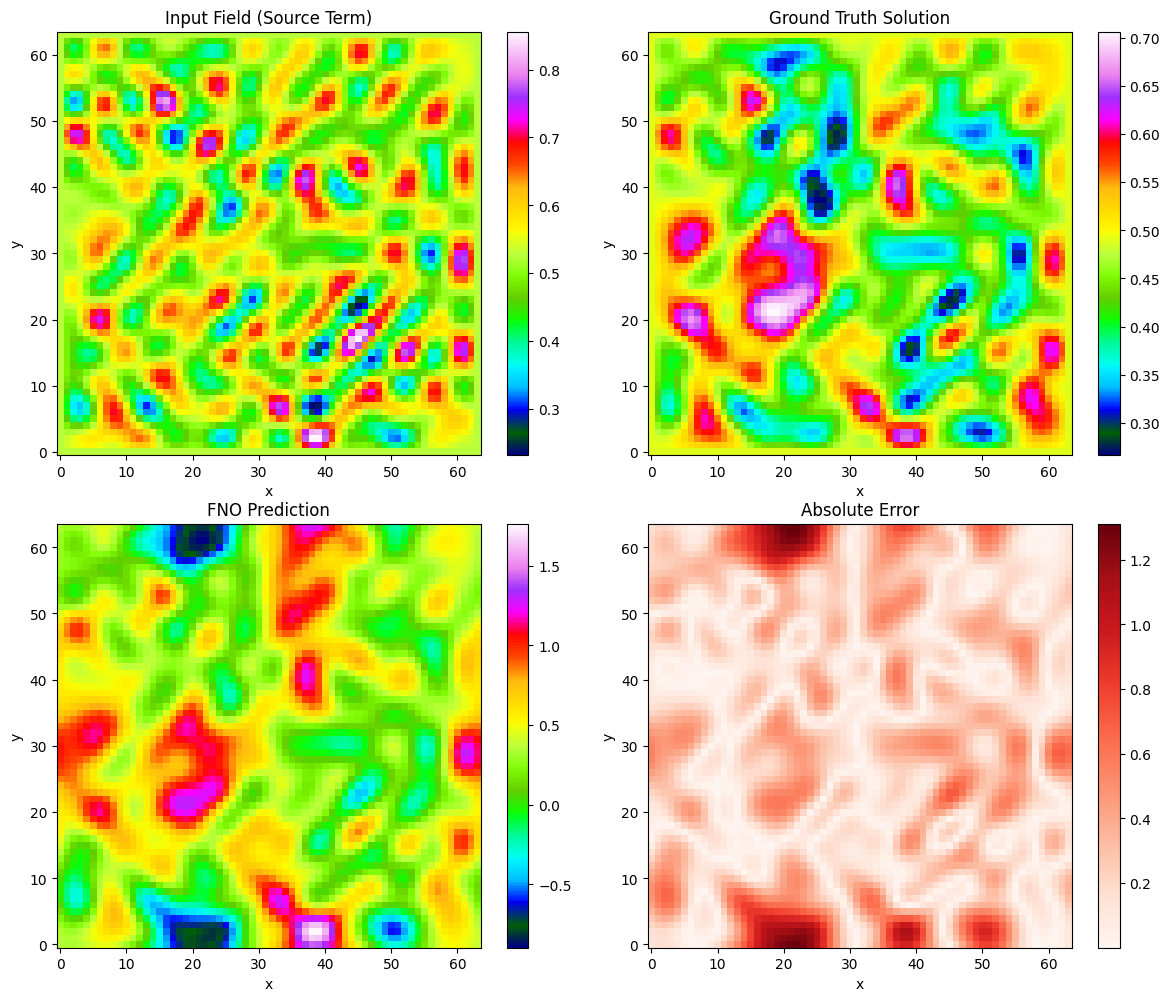

Relative L2 error for this sample: 0.7272 (72.72%)


In [23]:
# Visualize the results (same visualization as CNO)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Input field (source term)
im1 = axes[0, 0].imshow(input_sample, cmap=cmap, origin='lower')
axes[0, 0].set_title('Input Field (Source Term)')
axes[0, 0].set_xlabel('x')
axes[0, 0].set_ylabel('y')
plt.colorbar(im1, ax=axes[0, 0])

# Ground truth solution
im2 = axes[0, 1].imshow(ground_truth, cmap=cmap, origin='lower')
axes[0, 1].set_title('Ground Truth Solution')
axes[0, 1].set_xlabel('x')
axes[0, 1].set_ylabel('y')
plt.colorbar(im2, ax=axes[0, 1])

# Model prediction
im3 = axes[1, 0].imshow(prediction, cmap=cmap, origin='lower')
axes[1, 0].set_title('FNO Prediction')
axes[1, 0].set_xlabel('x')
axes[1, 0].set_ylabel('y')
plt.colorbar(im3, ax=axes[1, 0])

# Error map
error = np.abs(ground_truth - prediction)
im4 = axes[1, 1].imshow(error, cmap='Reds', origin='lower')
axes[1, 1].set_title('Absolute Error')
axes[1, 1].set_xlabel('x')
axes[1, 1].set_ylabel('y')
plt.colorbar(im4, ax=axes[1, 1])

plt.tight_layout()
plt.show()

# Calculate relative error for this sample
rel_error = np.linalg.norm(ground_truth - prediction) / np.linalg.norm(ground_truth)
print(f"Relative L2 error for this sample: {rel_error:.4f} ({rel_error*100:.2f}%)")


## 5. Multiple Sample Visualization

Let's visualize FNO predictions on multiple samples to get a better sense of model performance.


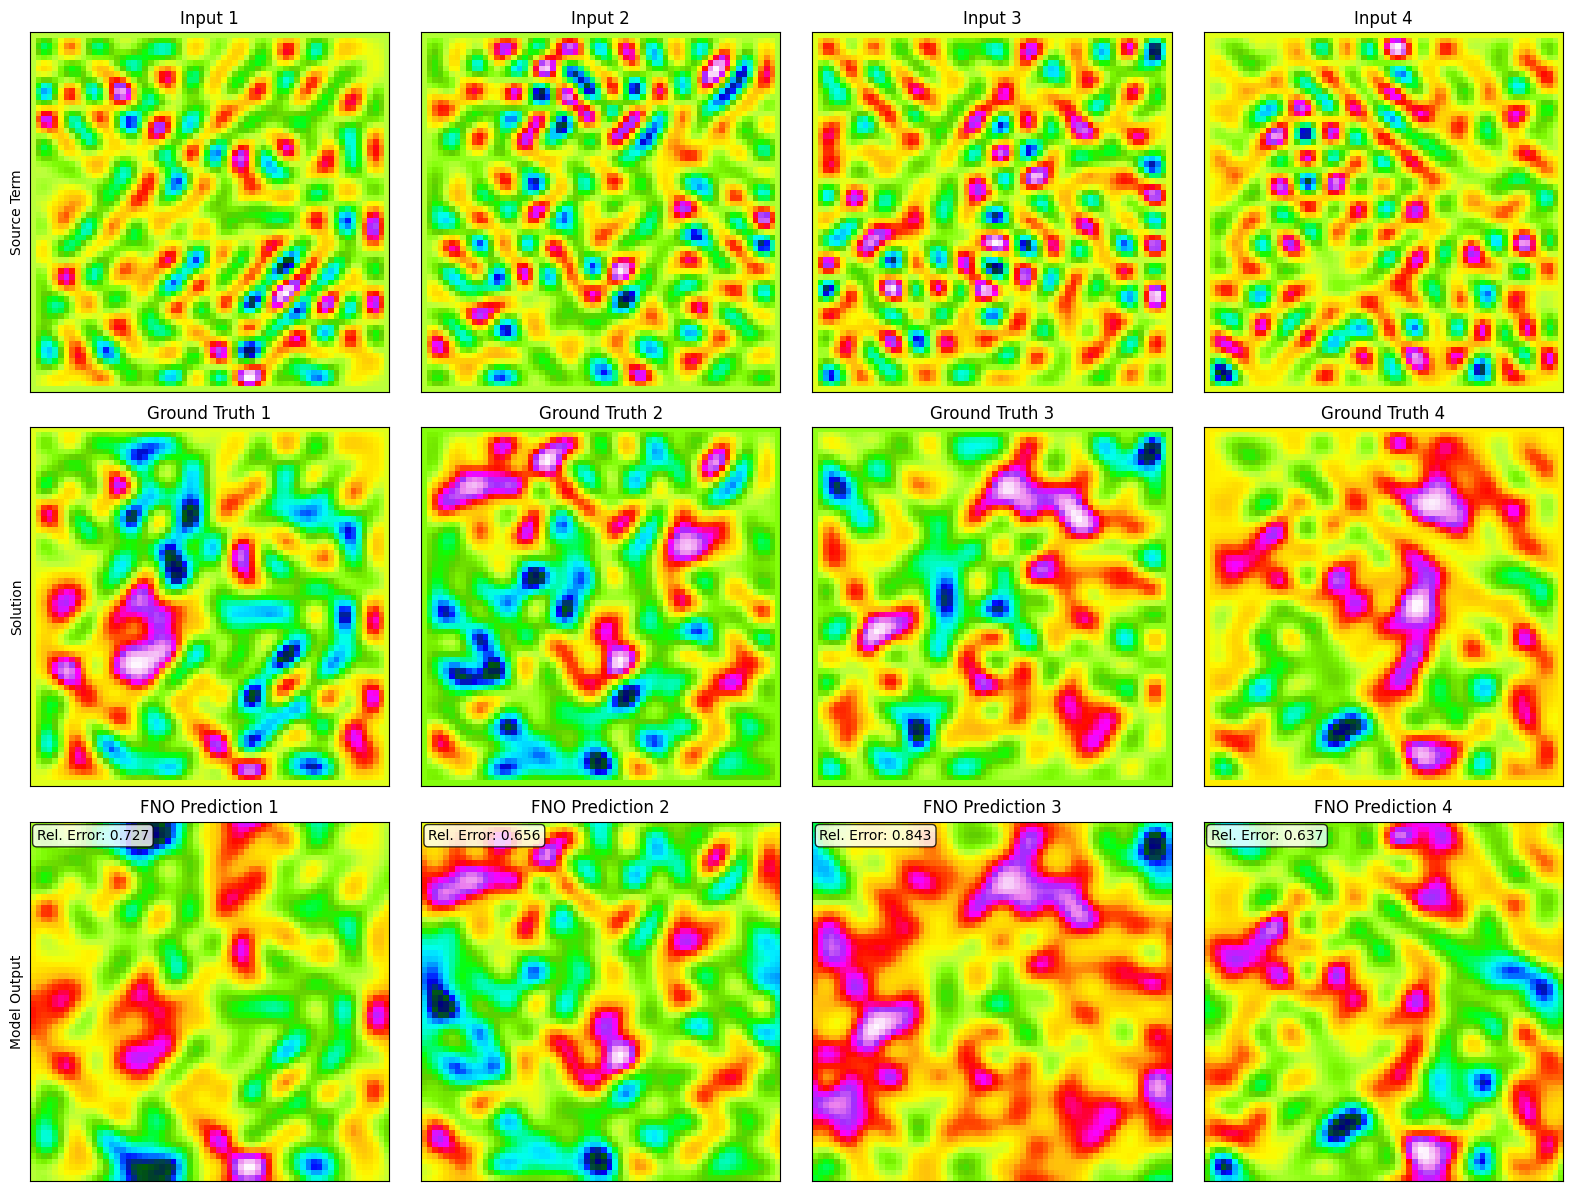

In [24]:
# Get multiple samples for visualization
num_samples = 4
test_iter = iter(poisson_data.test_loader)
input_batch, output_batch = next(test_iter)

# Take first few samples
input_batch = input_batch[:num_samples].to(device)
output_batch = output_batch[:num_samples].to(device)

# Get predictions
with torch.no_grad():
    prediction_batch = model(input_batch)

# Create visualization
fig, axes = plt.subplots(3, num_samples, figsize=(16, 12))

for i in range(num_samples):
    # Convert to numpy (note FNO format: [H, W, C])
    input_sample = input_batch[i, :, :, 0].cpu().numpy()
    ground_truth = output_batch[i, :, :, 0].cpu().numpy()
    prediction = prediction_batch[i, :, :, 0].cpu().numpy()
    
    # Plot input
    im1 = axes[0, i].imshow(input_sample, cmap=cmap, origin='lower')
    axes[0, i].set_title(f'Input {i+1}')
    if i == 0:
        axes[0, i].set_ylabel('Source Term')
    
    # Plot ground truth
    im2 = axes[1, i].imshow(ground_truth, cmap=cmap, origin='lower')
    axes[1, i].set_title(f'Ground Truth {i+1}')
    if i == 0:
        axes[1, i].set_ylabel('Solution')
    
    # Plot prediction
    im3 = axes[2, i].imshow(prediction, cmap=cmap, origin='lower')
    axes[2, i].set_title(f'FNO Prediction {i+1}')
    if i == 0:
        axes[2, i].set_ylabel('Model Output')
    
    # Calculate and display relative error
    rel_error = np.linalg.norm(ground_truth - prediction) / np.linalg.norm(ground_truth)
    axes[2, i].text(0.02, 0.98, f'Rel. Error: {rel_error:.3f}', 
                   transform=axes[2, i].transAxes, 
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                   verticalalignment='top')

# Remove axis ticks for cleaner look
for ax in axes.flat:
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()


## Conclusion

This notebook demonstrated how to:

1. **Load a pretrained FNO model** and its configuration from saved files
2. **Set up data loaders** with the same parameters used during FNO training  
3. **Perform inference** on individual samples and batches using FNO's [H×W×C] data format
4. **Visualize results** showing inputs, ground truth, predictions, and errors
5. **Evaluate model performance** across training, validation, and test sets using relative L1 error

The FNO model shows good performance on the Poisson equation benchmark, successfully learning to map from source terms to solutions using spectral convolutions in Fourier space.

### Key Observations:
- The FNO model generalizes well from training to test data
- Relative errors are typically low, indicating accurate predictions  
- The model captures both smooth and detailed features in the solutions
- Performance is consistent across different samples
- FNO uses a different data format ([H×W×C]) compared to CNO ([C×H×W])

### FNO vs CNO:
- **FNO** uses Fourier transforms and spectral convolutions
- **CNO** uses convolutional layers with anti-aliasing filters
- Both are neural operators capable of solving PDEs on different resolutions
- Error metrics may differ: FNO uses relative L1 error, CNO uses relative L2 error

### Important Note:
The model loading uses `weights_only=False` to handle the full model object (including architecture). This is safe for trusted model files but should be used with caution when loading models from untrusted sources.
